### TorchIP Models 
This notebook shows examples on how to build a (neural network) energy `model` and a `trainer` which consume energy and force components (gardient) to fit the model. 

#### TODO:
- train model using input + gradient of inputs
- fit example LJ potential

In [1]:
import sys
sys.path.append('../')

import math
import torch
from torch import nn
import matplotlib.pylab as plt

# TorchIP imports
import torchip
from torchip.config import CFG # TODO: improve it
from torchip.models import NeuralNetworkModel
from torchip.utils import gradient

In [2]:
CFG.set("device", "cpu")
print("Device:", CFG["device"])

Device: cpu


### Model

In [3]:
model = NeuralNetworkModel(input_size=1, layers=((10, 't'), (10, 't'), (1, 'l')))
print(model)

NeuralNetworkModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): Identity()
  )
)


In [21]:
def func(x):
    return torch.sum(torch.sin(x), dim=1).view(-1, 1)

def get_sample(n, requires_grad=False, factor=4):
    return torch.rand(n, 1, requires_grad=requires_grad)*math.pi*factor

x_train = get_sample(1000)
y_train = func(x_train)
# dy_train = gradient(y_train, x_train)

x_val = get_sample(100)
y_val = func(x_val)
# dy_val = gradient(y_val, x_val)

In [23]:
# plt.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="data")
# # plt.scatter(x_train.detach().numpy(), dy_train.detach().numpy(), label="derivative")
# plt.xlabel("x"); plt.ylabel("y, dy"); plt.legend();

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, optimizer, loss_fn, epochs=5000):
    """
    Train input model using provided optimizer, loss function, and data.
    """
    for epoch in range(epochs):
        # Training 
        training_loss = 0.0
        model.train()
        optimizer.zero_grad()
        y =  model(x_train)
        #dy = gradient(y, x_train)
        loss = criterion(y, y_train) #+ criterion(dy, dy_train)
        loss.backward(retain_graph=True)
        optimizer.step()
        training_loss += loss.data.item()
        
        # Validation
        valid_loss = 0.0
        model.eval()
        y =  model(x_val)
        #dy = gradient(y, x_val)
        loss = criterion(y, y_val) #+ criterion(dy, dy_val)
        valid_loss += loss.data.item()
        
        # Print
        if epoch==0 or (epoch+1) % 500 == 0:
            print(f'Epoch: [{epoch+1}/{epochs}], Training Loss: {training_loss:.8f}, Valid Loss: {valid_loss:.8f}')

In [26]:
train(model, optimizer, criterion)

Epoch: [1/5000], Training Loss: 0.00024044, Valid Loss: 0.00022922
Epoch: [500/5000], Training Loss: 0.00015697, Valid Loss: 0.00015717
Epoch: [1000/5000], Training Loss: 0.00010801, Valid Loss: 0.00010838
Epoch: [1500/5000], Training Loss: 0.00007630, Valid Loss: 0.00007665
Epoch: [2000/5000], Training Loss: 0.00005582, Valid Loss: 0.00005597
Epoch: [2500/5000], Training Loss: 0.00004214, Valid Loss: 0.00004203
Epoch: [3000/5000], Training Loss: 0.00003281, Valid Loss: 0.00003245
Epoch: [3500/5000], Training Loss: 0.00002621, Valid Loss: 0.00002566
Epoch: [4000/5000], Training Loss: 0.00002149, Valid Loss: 0.00002088
Epoch: [4500/5000], Training Loss: 0.00001799, Valid Loss: 0.00001732
Epoch: [5000/5000], Training Loss: 0.00001531, Valid Loss: 0.00001475


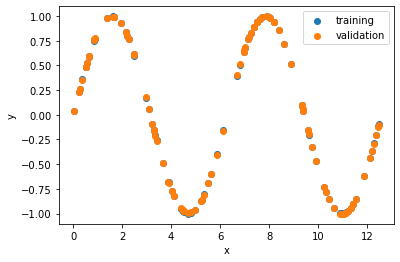

In [27]:
plt.scatter(x_val, y_val, label="training")
plt.scatter(x_val, model(x_val).detach().numpy(), label="validation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend();

Text(0.5, 1.0, 'Gradient')

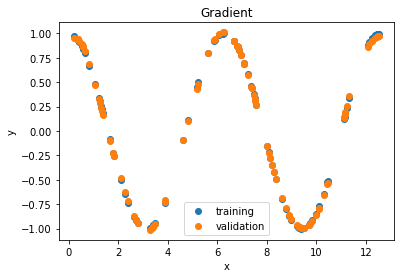

In [29]:
x = get_sample(100, True)
plt.scatter(x.detach().numpy(), gradient(func(x), x).detach().numpy(), label="training")
plt.scatter(x.detach().numpy(), gradient(model(x), x).detach().numpy(), label="validation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.title("Gradient")